# IMPORT LIBRARIES

In [40]:

# Garbage collection
import gc

# Misc libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random

# import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.data import Dataset
from tensorflow.keras import backend as K


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Word2Vec Librari
import gensim.downloader as api
import gensim
from gensim.models import KeyedVectors


# CONSTANTS

In [2]:
# CONSTANT TO USE DURING THE BUILDING OF EMBEDDING LAYER

BYTECODE_AS_STRINGS = ["".join(str(i)) for i in range(256)]


# LOADING THE PRE-TRAINED WORD2VEC 

In [3]:
# Load custom Word2Vec model
word_vectors = KeyedVectors.load("custom_bytecode_word2vec.kv")

# 1. Convert the Word2Vec model into a matrix (embedding matrix)
EMBEDDING_MATRIX = np.zeros((256, word_vectors.vector_size))  # 256 bytecodes, each with embedding_dim dimensions

# Fill the embedding matrix with the word vectors
for i in range(256):
    bytecode_str = str(i)
    EMBEDDING_MATRIX[i] = word_vectors[bytecode_str]

# 2. Check the dimensions of the embedding matrix
print(f"Embedding Matrix Shape: {EMBEDDING_MATRIX.shape}")
print(f"Embedding Dimension: {EMBEDDING_MATRIX.shape[1]}")

print(EMBEDDING_MATRIX)

Embedding Matrix Shape: (256, 32)
Embedding Dimension: 32
[[ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 [ 0.05078125 -0.09326172  0.06494141 ...  0.15820312 -0.20800781
  -0.17285156]
 [ 0.10693359 -0.10546875  0.05322266 ...  0.02868652 -0.20898438
  -0.1484375 ]
 ...
 [ 0.11214193 -0.07991537  0.05143229 ... -0.00665283 -0.23502605
  -0.15787761]
 [ 0.08683268 -0.07698568  0.05175781 ... -0.00132243 -0.24153645
  -0.16634114]
 [ 0.11214193 -0.06901041  0.06266276 ...  0.00366211 -0.24804688
  -0.171875  ]]


# 1. DATASET PROCESSING

## 1.1 CONSTANTS

In [4]:
# SAMPLE RELATED CONSTANTS
ROOT_DIR = '/mnt/d/NOTES-ARCHIVE/MALWARE ANALYSIS/Android malware dataset/processed/'

BENIGN_SAMPLE = 20
ADWARE_SAMPLE = 10
SMS_SAMPLE = 8
BANKING_SAMPLE = 8

BYTECODE_LENGTH=65536

DATA_CATEGORY =  ['Adware', 'SMS', 'Banking', 'Benign']

NUMBER_OF_SAMPLE = ADWARE_SAMPLE + BANKING_SAMPLE + SMS_SAMPLE + BENIGN_SAMPLE
MALWARE_SAMPLE = ADWARE_SAMPLE + SMS_SAMPLE + BANKING_SAMPLE

P = 32 # Dimension after trimming of each word2vec vector, incresing this might lead to better perfomance

SAMPLE_NUMBER= {
    'Benign':1199,
    'Banking':2240,
    'Adware':1512,
    'SMS':4816
}
gc.collect()

0

## 1.1 ONE-HOT ENCODING FUNCTION

In [5]:
# This function takes a byte sequence and returns one-hot encoded form of it

def one_hot_encode(array, num_classes=256):

    array = np.array(array)  # Ensure input is a NumPy array
    if np.any(array < 0) or np.any(array >= num_classes):
        raise ValueError(f"All elements in the array must be in the range [0, {num_classes-1}]")
    
    one_hot = np.zeros((array.size, num_classes), dtype=np.uint8)  # Create a matrix of zeros
    one_hot[np.arange(array.size), array] = 1  # Set the appropriate indices to 1
    return one_hot

## 1.2 SINGLE SAMPLE PROCESSING FUNCTIONS

In [6]:
def multiply_with_weights(one_hot_matrix):
    embedded_sequence = np.dot(one_hot_matrix, EMBEDDING_MATRIX)
    return embedded_sequence


In [7]:
def get_and_process_sample(path):
    file_data = open(path, 'rb').read(BYTECODE_LENGTH)

    bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
    bytes_sequence = multiply_with_weights(one_hot_encode(bytes_sequence))
    
    return bytes_sequence

## 1.3 PROCESSING ALL THE SAMPLES

In [8]:
# Test 
test = get_and_process_sample('Benign_0596/data_section.bin')
print(f'{test}\nshape: {test.shape}')
print(f"First element datatype: {type(test[0, 0])}")

[[ 0.11474609 -0.08349609  0.03369141 ... -0.03979492 -0.22851562
  -0.14160156]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 ...
 [ 0.10693359 -0.10546875  0.05322266 ...  0.02868652 -0.20898438
  -0.1484375 ]
 [ 0.08972168 -0.05096436  0.03381348 ... -0.04315186 -0.22802734
  -0.22119141]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]]
shape: (65536, 32)
First element datatype: <class 'numpy.float64'>


In [9]:
def get_data(label, count):
    data = []
    for i in range(count):
        file_data = get_and_process_sample(ROOT_DIR+f'{label}_500/{label}_{str(i).zfill(4)}/data_section.bin')
        data.append(file_data)
        
    return data


In [10]:
benign_data = get_data('Benign', BENIGN_SAMPLE)
adware_data = get_data('Adware', ADWARE_SAMPLE)
sms_data = get_data('SMS', SMS_SAMPLE)
banking_data = get_data('Banking', BANKING_SAMPLE)
labels = np.array([0 for i in range(BENIGN_SAMPLE)] + [1 for i in range(MALWARE_SAMPLE)])
gc.collect()

0

In [11]:
# Test: Print the first element in each dataset
# print(f"First element in Benign data: {benign_data[0]}\nDimension:{benign_data[0].shape}", )
# print(f"First element in Adware data: {adware_data[0]}\nDimension:{adware_data[0].shape}", adware_data[0])
# print(f"First element in SMS data: {sms_data[0]}\nDimension:{sms_data[0].shape}", sms_data[0])
# print(f"First element in Banking data: {banking_data[0]}\nDimension:{banking_data[0].shape}", banking_data[0])

## 1.4 CREATING DATA SET

In [12]:
# Labels for the data
benign_label = 0
other_label = 1

# Combine all the data and assign labels
X_data = []
y_labels = []

# Add benign data (label 0)
X_data.extend(benign_data)  # Add benign embeddings
y_labels.extend([benign_label] * len(benign_data))  # Add 0 labels for benign data
del benign_data

# Add adware data (label 1)
X_data.extend(adware_data)  # Add adware embeddings
y_labels.extend([other_label] * len(adware_data))  # Add 1 labels for adware data
del adware_data

gc.collect()

# Add SMS data (label 1)
X_data.extend(sms_data)  # Add sms embeddings
y_labels.extend([other_label] * len(sms_data))  # Add 1 labels for sms data
del sms_data


# Add banking data (label 1)
X_data.extend(banking_data)  # Add banking embeddings
y_labels.extend([other_label] * len(banking_data))  # Add 1 labels for banking data
del banking_data

# Convert lists to NumPy arrays
X_data = np.array(X_data)
y_labels = np.array(y_labels)

gc.collect()

# Create a TensorFlow Dataset from the data
dataset = Dataset.from_tensor_slices((X_data, y_labels))


I0000 00:00:1735151644.784804     632 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=NUMBER_OF_SAMPLE, seed=42)

# Split into training and validation datasets
train_size = int(0.8 * NUMBER_OF_SAMPLE)  # 80% for training
train_dataset = dataset.take(train_size)  # First 80%
val_dataset = dataset.skip(train_size)    # Remaining 20%

# Batch the datasets
batch_size = 10 # You can adjust this
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [14]:
# for X_batch, y_batch in dataset.take(1):
#     print(f"Features batch shape: {X_batch.shape}")  # Shape of features
#     print(f"Labels batch shape: {y_batch.shape}")    # Shape of labels

# 2. MODEL BUILDING

In [46]:
def build_model():
    # Define input
    input_layer = Input(shape=(BYTECODE_LENGTH,32), name="Input_Layer")

    # Convolutional and pooling layers
    conv_layers = []
    for kernel_size in [2, 3, 4, 5, 6, 7, 8]:
        x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same',
                   name=f"Conv1D_Kernel_{kernel_size}")(input_layer)
        pooled = GlobalMaxPooling1D(name=f"GlobalMaxPooling_Kernel_{kernel_size}")(x)
        conv_layers.append(pooled)

    # Aggregation
    aggregation_layer = Concatenate(name="Aggregation_Layer")(conv_layers)


    # Fully connected layer with Dropout
    fully_connected = Dense(512, activation='relu', name="Fully_Connected_Layer")(aggregation_layer)
    dropout_layer = Dropout(0.5, name="Dropout_Layer")(fully_connected)

    # Output layer
    output_layer = Dense(2, activation='softmax', name="Output_Layer")(dropout_layer)

    # # Argmax layer to find the index with the maximum value
    # argmax_output = Lambda(lambda x: K.argmax(x, axis=-1), output_shape=(1,),name="Argmax_Layer")(output_layer)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name="CNN_Model")

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
# Define input
input_layer = Input(shape=(BYTECODE_LENGTH,32), name="Input_Layer")

# Convolutional and pooling layers
conv_layers = []
for kernel_size in [2, 3, 4, 5, 6, 7, 8]:
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same',
               name=f"Conv1D_Kernel_{kernel_size}")(input_layer)
    pooled = GlobalMaxPooling1D(name=f"GlobalMaxPooling_Kernel_{kernel_size}")(x)
    conv_layers.append(pooled)

# Aggregation
aggregation_layer = Concatenate(name="Aggregation_Layer")(conv_layers)


# Fully connected layer with Dropout
fully_connected = Dense(512, activation='relu', name="Fully_Connected_Layer")(aggregation_layer)
dropout_layer = Dropout(0.5, name="Dropout_Layer")(fully_connected)

# Output layer
output_layer = Dense(2, activation='softmax', name="Output_Layer")(dropout_layer)

# # Argmax layer to find the index with the maximum value
# argmax_output = Lambda(lambda x: K.argmax(x, axis=-1), output_shape=(1,),name="Argmax_Layer")(output_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer, name="CNN_Model")

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 65536, 32) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_2     │ (None, 65536, 64) │      4,160 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_3     │ (None, 65536, 64) │      6,208 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_4     │ (None, 65536, 64) │      8,256 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_5     │ (None, 65536, 64) │     10,304 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_6     │ (None, 65536, 64) │     12,352 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_7     │ (None, 65536, 64) │     14,400 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_Kernel_8     │ (None, 65536, 64) │     16,448 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_2[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_3[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_4[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_5[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_6[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_7[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Conv1D_Kernel_8[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Aggregation_Layer   │ (None, 448)       │          0 │ GlobalMaxPooling… │
│ (Concatenate)       │                   │            │ GlobalMaxPooling… │
│                     │                   │            │ GlobalMaxPooling… │
│                     │                   │            │ GlobalMaxPooling

 Total params: 303,042 (1.16 MB)

 Trainable params: 303,042 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

# 3. TRAINING

In [44]:
def model_training(epoch):
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset, 
        epochs=epoch,  # Adjust epochs as needed
        verbose=1
    )

In [ ]:

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=100,  # Adjust epochs as needed
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# 4. PLOTTING

## 4.1 Loss

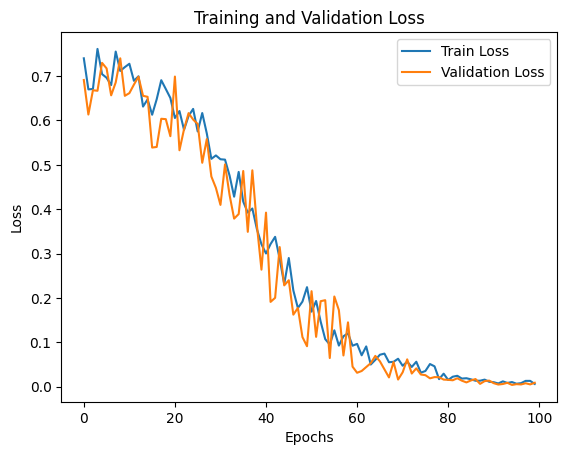

In [17]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4.2 Accuracy graph and confusion matrix

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy over epochs.

    Args:
    history (tf.keras.callbacks.History): The history object returned by model.fit().

    Returns:
    None
    """
    # Extract training and validation accuracy
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final accuracy
    print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
    print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

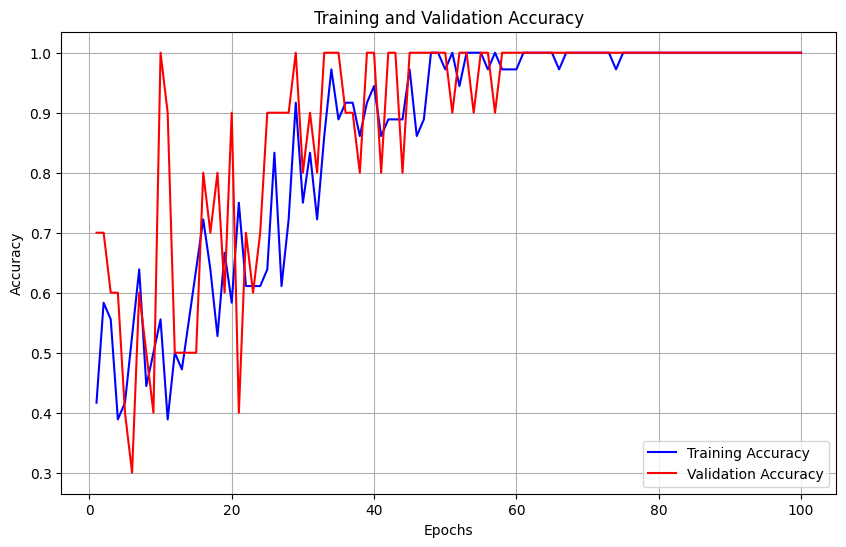

Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


In [19]:
plot_training_history(history)

In [20]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return conf_matrix

## 4.3 Report  Precision, Recall, F1-Score, and Support.

In [21]:
def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['Benign','Malware'])
    print("Classification Report:")
    return report


In [38]:
def plot_accuracy(y_true,y_pred):
    return accuracy_score(y_true, y_pred)

# 5. PREDICT WITH NEVER SEEN DATA

## 5.1 Testing with individual samples

In [22]:
test_sample=get_and_process_sample('./Benign_0596/data_section.bin')
# Add batch dimension
test_sample = np.expand_dims(test_sample, axis=0)  # Shape becomes (1, 65536, 3
print(model.predict(test_sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
[[0.91770726 0.0822927 ]]


## 5.2 Testing on a test dataset

In [23]:
NUMBER_OF_TEST_SAMPLE = 50

In [29]:
def testing(model):
    y_pred=[]
    y_true=[]
    sample_count = 0
    while sample_count < NUMBER_OF_TEST_SAMPLE:

        category= DATA_CATEGORY[random.randint(0,3)]

        id=random.randint(BENIGN_SAMPLE,SAMPLE_NUMBER[category])
        if(category=='Benign'):
            true_label=0
        else:
            true_label=1

        print('Path:',ROOT_DIR+f'{category}_500/{category}_{str(id).zfill(4)}/data_section.bin')


        test_sample=get_and_process_sample(ROOT_DIR+f'{category}_500/{category}_{str(id).zfill(4)}/data_section.bin')
        test_sample = np.expand_dims(test_sample, axis=0)
        prediction = model.predict(test_sample)

        print('Prediction:',prediction)

        predicted_classes = np.argmax(prediction, axis=1)  # Get class indices (0 or 1)
        y_true.append(true_label)  # Add true labels
        y_pred.extend(predicted_classes)  # Add predictions
        sample_count+=1

    return (y_true, y_pred)

In [ ]:
y_true,y_pred=testing(model)
print('Y_TRUE:')
print(y_true)
print('Y_PRED:')
print(y_pred)
gc.collect()

In [49]:
def testing_2(model):
    y_pred=[]
    y_true=[]
    sample_count = 0
    while sample_count < NUMBER_OF_TEST_SAMPLE:

        category= DATA_CATEGORY[random.randint(0,3)]

        id=random.randint(BENIGN_SAMPLE,SAMPLE_NUMBER[category])
        if(category=='Benign'):
            true_label=0
        else:
            true_label=1

        test_sample=get_and_process_sample(ROOT_DIR+f'{category}_500/{category}_{str(id).zfill(4)}/data_section.bin')
        test_sample = np.expand_dims(test_sample, axis=0)
        prediction = model.predict(test_sample)

        predicted_classes = np.argmax(prediction, axis=1)  # Get class indices (0 or 1)
        y_true.append(true_label)  # Add true labels
        y_pred.extend(predicted_classes)  # Add predictions
        sample_count+=1

    return (y_true, y_pred)

## 5.3 Plot confusion matrix

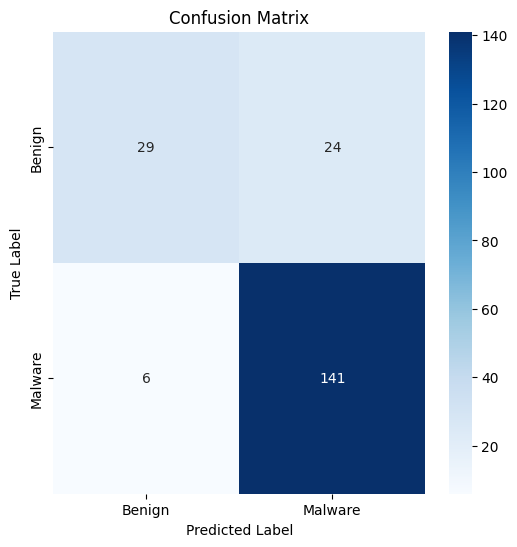

array([[ 29,  24],
       [  6, 141]])

In [31]:
plot_confusion_matrix(y_true,y_pred)

## 5.4 Plot report

In [52]:
report = plot_classification_report(y_true,y_pred)
print(report)



report = plot_accuracy(y_true,y_pred)
print(report)

Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.74      0.80        58
     Malware       0.90      0.95      0.92       142

    accuracy                           0.89       200
   macro avg       0.88      0.85      0.86       200
weighted avg       0.89      0.89      0.89       200

{'Benign': {'precision': 0.86, 'recall': 0.7413793103448276, 'f1-score': 0.7962962962962963, 'support': 58.0}, 'Malware': {'precision': 0.9, 'recall': 0.9507042253521126, 'f1-score': 0.9246575342465754, 'support': 142.0}, 'accuracy': 0.89, 'macro avg': {'precision': 0.88, 'recall': 0.8460417678484702, 'f1-score': 0.8604769152714358, 'support': 200.0}, 'weighted avg': {'precision': 0.8884000000000001, 'recall': 0.89, 'f1-score': 0.8874327752409944, 'support': 200.0}}
0.89


In [ ]:
accuracy_list = []
true_positive_rate=[]
false_positive_rate=[]
epoch_ranges = [i for i in range(5,101,5)]

for epoch_count in epoch_ranges:
    model = build_model()
    model_training(epoch_count)
    y_true,y_pred=testing_2(model)

    # Extract TP and FP
    conf_mat = confusion_matrix(y_true,y_pred)
    TP = conf_mat[1, 1] / NUMBER_OF_TEST_SAMPLE  # True Positives are at position [1, 1]
    FP = conf_mat[0, 1] / NUMBER_OF_TEST_SAMPLE # False Positives are at position [0, 1]

    true_positive_rate.append(TP)
    false_positive_rate.append(FP)
    
    accuracy_list.append(plot_accuracy(y_true,y_pred))

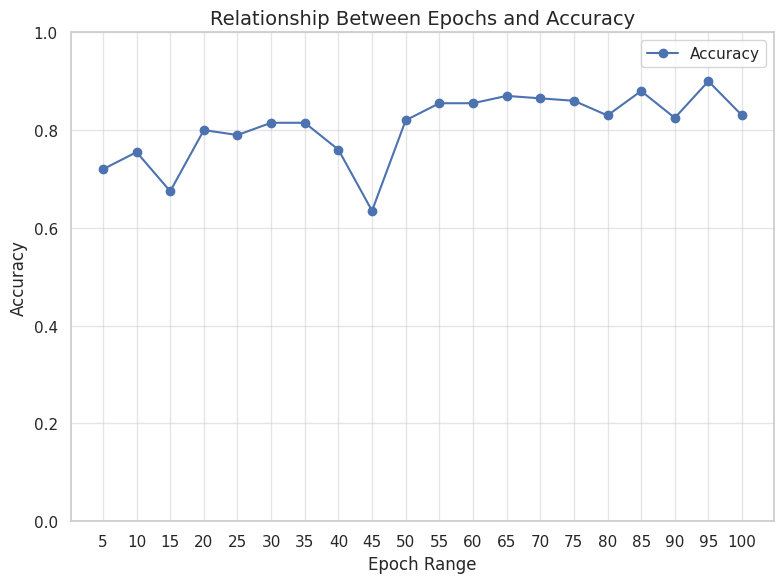

In [54]:
# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(epoch_ranges, accuracy_list, marker='o', linestyle='-', color='b', label="Accuracy")

# Add labels, title, and legend
plt.title("Relationship Between Epochs and Accuracy", fontsize=14)
plt.xlabel("Epoch Range", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(epoch_ranges)
plt.ylim(0, 1)  # Accuracy range is 0 to 1
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

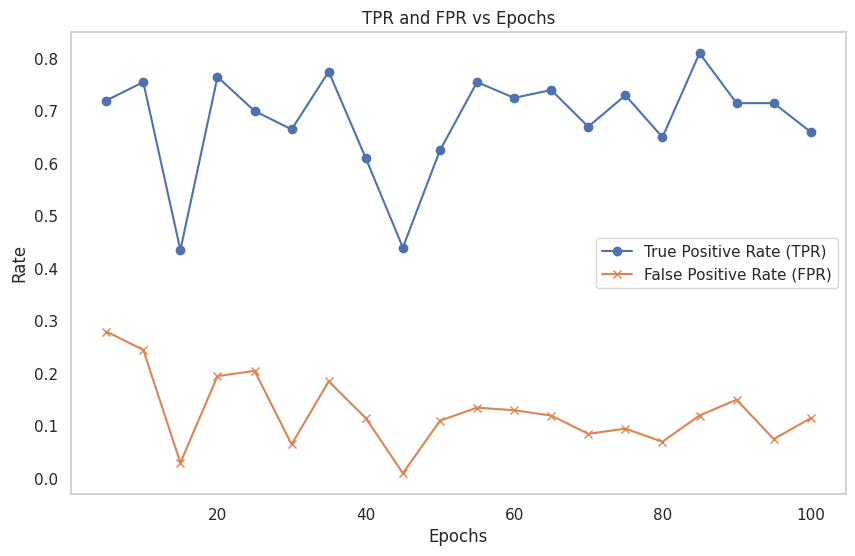

In [55]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epoch_ranges, true_positive_rate, label='True Positive Rate (TPR)', marker='o')
plt.plot(epoch_ranges, false_positive_rate, label='False Positive Rate (FPR)', marker='x')

# Customize the plot
plt.title('TPR and FPR vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

# EXTRAS: CREATE EMBEDDING WEIGHT MATRIX

In [97]:
# This function trims the synthesize_embedding into P dimension vector
def trim_to_dimensions(embedding): 
    trimmed_embedding = embedding[:P]  # Take the first P elements
    return trimmed_embedding

In [98]:
# This function synthesize values for bytes value greater than 10 since word2vec-google-news-300 does not have information about these values

def synthesize_embedding(model, number):
    digits = list(str(number))  # Split the number into its digits
    print(digits)
    digit_embeddings = []
    
    for digit in digits:
        if digit in model:
            digit_embeddings.append(model[digit])
        else:
            raise ValueError(f"Embedding for digit '{digit}' not found in the model.")
    
    # Compute the average embedding for the number
    synthesized_embedding = np.mean(digit_embeddings, axis=0)
    
    # Perform trimming to fit the dimenstion P
    synthesized_embedding=trim_to_dimensions(synthesized_embedding)

    return synthesized_embedding

In [99]:
wv = api.load('word2vec-google-news-300')
word_vectors = KeyedVectors(vector_size=P)
embedding_vectors=[]

for bytecode_value in range(0,256):

    bytecode_id = str(bytecode_value)

    bytecode_embedding = synthesize_embedding(wv,bytecode_value)

    embedding_vectors.append(bytecode_embedding)

    print(bytecode_embedding,'\n', bytecode_embedding.shape)
    gc.collect()



word_vectors.add_vectors(BYTECODE_AS_STRINGS, embedding_vectors)

word_vectors.save("custom_bytecode_word2vec.kv")

print("Custom Word2Vec model saved successfully.")

## TESTING THE EMBEDDING LAYER

In [100]:
# Load the saved KeyedVectors model
loaded_vectors = KeyedVectors.load("custom_bytecode_word2vec.kv")

# Example: Accessing the vector for bytecode "5"
for i in range(5):
    vector_for_5 = loaded_vectors[str(i)]

    bytecode_embedding = synthesize_embedding(wv,i)

    print(f"Vector for bytecode {i}: {vector_for_5}")

    print(f'Synthesized value for bytecode {i}: {bytecode_embedding}')
    gc.collect()
